# 5 Common LLM Parameters Explained
LLMs offer several parameters that let you fine-tune their behavior and control how they generate responses. If a model isn’t producing the desired output, the issue often lies in how these parameters are configured. In this tutorial, we’ll explore some of the most commonly used ones — **max_completion_tokens**, **temperature**, **top_p**, **presence_penalty**, and **frequency_penalty** — and understand how each influences the model’s output.

## Installing the dependencies

In [76]:
!pip install openai pandas matplotlib

### Loading OpenAI API Key

In [1]:
import os
from getpass import getpass
os.environ['OPENAI_API_KEY'] = getpass('Enter OpenAI API Key: ')

Enter OpenAI API Key: ··········


## Initializing the Model

In [2]:
from openai import OpenAI
model="gpt-4.1"
client = OpenAI()

## Max Tokens

Max Tokens is the maximum number of tokens the model can generate during a run. The model will try to stay within this limit across all turns. If it exceeds the specified number, the run will stop and be marked as incomplete.

A smaller value (like 16) limits the model to very short answers, while a higher value (like 80) allows it to generate more detailed and complete responses. Increasing this parameter gives the model more room to elaborate, explain, or format its output more naturally.

In [3]:
prompt = "What is the most popular French cheese?"
for tokens in [16, 30, 80]:
  print(f"\n--- max_output_tokens = {tokens} ---")
  response = client.chat.completions.create(
    model=model,
    messages=[
      {"role": "developer", "content": "You are a helpful assistant."},
      {"role": "user", "content": prompt}
    ],
    max_completion_tokens=tokens
  )
  print(response.choices[0].message.content)


--- max_output_tokens = 16 ---
The most popular French cheese—both in terms of production and consumption—is **Cam

--- max_output_tokens = 30 ---
The most popular French cheese is **Camembert**. Known for its creamy texture and distinctive earthy flavor, Camembert is widely enjoyed in France

--- max_output_tokens = 80 ---
The most popular French cheese is **Camembert**. Camembert is iconic both in France and internationally, known for its soft, creamy texture and strong, earthy flavor. While France boasts hundreds of different cheeses—including Brie, Roquefort, Comté, and Emmental—Camembert is widely regarded as the country's classic cheese both in terms of production volume and cultural recognition. In


In [6]:
response.choices[0].finish_reason

'length'

We can see that in the last output, the model couldn't give the full answer, which is also depicted by the finish_reason parameters in the response.

## Temperature
In Large Language Models (LLMs), the temperature parameter controls the diversity and randomness of generated outputs. Lower temperature values make the model more deterministic and focused on the most probable responses — ideal for tasks that require accuracy and consistency. Higher values, on the other hand, introduce creativity and variety by allowing the model to explore less likely options. Technically, temperature scales the probabilities of predicted tokens in the softmax function: increasing it flattens the distribution (more diverse outputs), while decreasing it sharpens the distribution (more predictable outputs).

In this code, we’re prompting the LLM to give 10 different responses (n_choices = 10) for the same question — “***What is one intriguing place worth visiting?***” — across a range of temperature values. By doing this, we can observe how the diversity of answers changes with temperature. Lower temperatures will likely produce similar or repeated responses, while higher temperatures will show a broader and more varied distribution of places.

In [28]:
prompt = "What is one intriguing place worth visiting? Give a single-word answer and think globally."

temperatures = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5]
n_choices = 10
results = {}

for temp in temperatures:
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=temp,
        n=n_choices
    )

    # Collect all n responses in a list
    results[temp] = [response.choices[i].message.content.strip() for i in range(n_choices)]

# Display results
for temp, responses in results.items():
    print(f"\n--- temperature = {temp} ---")
    print(responses)


--- temperature = 0.2 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 0.4 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 0.6 ---
['Petra', 'Petra', 'Kyoto', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 0.8 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 1.0 ---
['Petra', 'Petra', 'Petra', 'Kyoto', 'Kyoto', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 1.2 ---
['Petra', 'Petra', 'Petra', 'Kyoto', 'Petra', 'Kyoto', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 1.5 ---
['Kyoto', 'Petra', 'Kyoto', 'Petra', 'Petra', 'Machu Picchu', 'Petra', 'Petra', 'Petra', 'Petra']


### Formatting the result and visualizing it

In [8]:
def clean_response(resp):
  resp = resp.replace('**', '')     # remove markdown bold
  resp = resp.strip('.').strip()    # remove trailing period and spaces
  return resp.lower()

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_temperature_responses(results: dict):
    """
    Plots a stacked bar chart showing percentage distribution
    of responses across temperature values.

    Parameters:
    -----------
    results : dict
        Dictionary of the form:
        {
            0.2: ['Fennec', 'Fennec', ...],
            0.4: ['Fennec', 'Axolotl', ...],
            ...
        }
    """
    # Convert results to DataFrame
    df = pd.DataFrame([
        {'temperature': temp, 'response': clean_response(resp)}
        for temp, responses in results.items()
        for resp in responses
    ])

    df['response_display'] = df['response'].str.capitalize()
    counts = df.groupby(['temperature', 'response']).size().unstack(fill_value=0)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    percentages_sorted = percentages.apply(lambda x: x.sort_values(ascending=False).index, axis=1)

    sorted_cols = percentages.sum().sort_values(ascending=False).index
    percentages = percentages[sorted_cols]

    # Plot stacked bar chart
    ax = percentages.plot(
        kind='bar',
        stacked=True,
        figsize=(8, 5),
        colormap='tab20'
    )

    # Add horizontal dotted line at 80%
    plt.axhline(50, color='black', linestyle='--', linewidth=1, label='50%')

    plt.title("Response Distribution Across Temperatures")
    plt.xlabel("Temperature")
    plt.ylabel("Percentage of Responses")
    plt.legend(title="Response", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


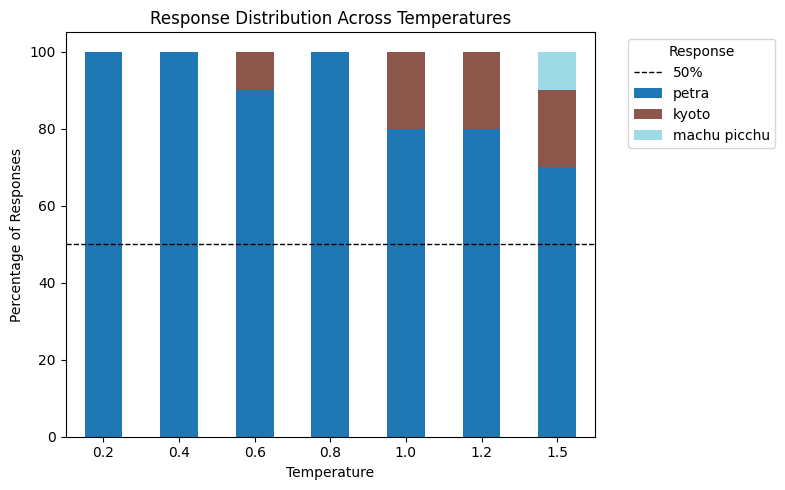

In [33]:
plot_temperature_responses(results)

As we can see, as the temperature increases to 0.6, the responses become more diverse, moving beyond the repeated single answer *“Petra*.” At a higher temperature of 1.5, the distribution shifts, and we can see responses like **Kyoto**, and **Machu Picchu** as well.

## Top P

Top P (also known as nucleus sampling) is a parameter that controls how many tokens the model considers based on a cumulative probability threshold. It helps the model focus on the most likely tokens, often improving coherence and output quality.

In the following visualization, we first set a temperature value and then apply Top P = 0.5 (50%), meaning only the top 50% of the probability mass is kept. Note that when temperature = 0, the output is deterministic, so Top P has no effect.

The generation process works as follows:

* Apply the temperature to adjust the token probabilities.

* Use Top P to retain only the most probable tokens that together make up 50% of the total probability mass.

* Renormalize the remaining probabilities before sampling.

We’ll visualize how the token probability distribution changes across different temperature values for the question:

“***What is one intriguing place worth visiting?***”

In [30]:
prompt = "What is one intriguing place worth visiting? Give a single-word answer and think globally."

temperatures = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5]
n_choices = 10
results_ = {}

for temp in temperatures:
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=temp,
        n=n_choices,
        top_p=0.5
    )

    # Collect all n responses in a list
    results_[temp] = [response.choices[i].message.content.strip() for i in range(n_choices)]

# Display results
for temp, responses in results_.items():
    print(f"\n--- temperature = {temp} ---")
    print(responses)


--- temperature = 0.2 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 0.4 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 0.6 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 0.8 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 1.0 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 1.2 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']

--- temperature = 1.5 ---
['Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra', 'Petra']


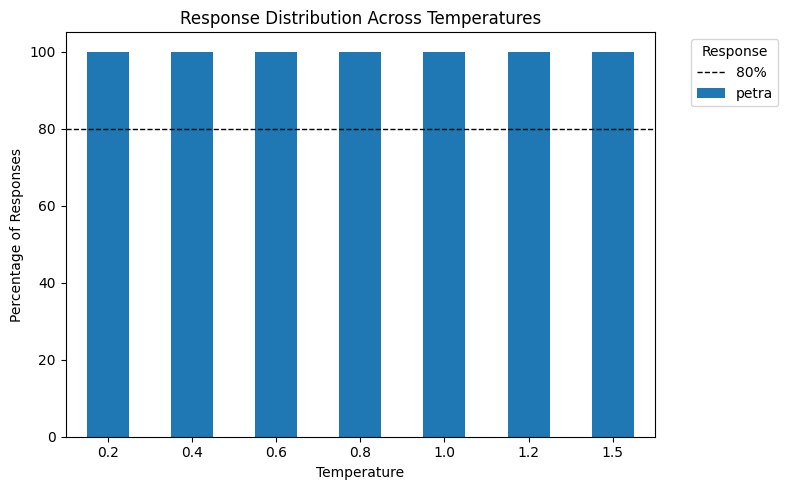

In [31]:
plot_temperature_responses(results_)

Since Petra consistently accounted for more than 50% of the total response probability, applying Top P = 0.5 filters out all other options. As a result, the model only selects “Petra” as the final output in every case.

## Frequency Penalty
Frequency Penalty controls how much the model avoids repeating the same words or phrases in its output.

* Range: -2 to 2

* Default: 0

When the frequency penalty is higher, the model gets penalized for using words it has already used before. This encourages it to choose new and different words, making the text more varied and less repetitive.

In simple terms — a higher frequency penalty = less repetition and more creativity.

We’ll test this using the prompt:

“***List 10 possible titles for a fantasy book. Give the titles only and each title on a new line.***”

In [112]:
prompt = "List 10 possible titles for a fantasy book. Give the titles only and each title on a new line."
frequency_penalties = [-2.0, -1.0, 0.0, 0.5, 1.0, 1.5, 2.0]
results = {}

for fp in frequency_penalties:
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        frequency_penalty=fp,
        temperature=0.2
    )

    text = response.choices[0].message.content
    items = [line.strip("- ").strip() for line in text.split("\n") if line.strip()]
    results[fp] = items

# Display results
for fp, items in results.items():
    print(f"\n--- frequency_penalty = {fp} ---")
    print(items)


--- frequency_penalty = -2.0 ---
['1. The Shadow Weaver’s Oath', '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir', '4. Song of the Forgotten Realms', '5. The Moonlit Blade', '6. The Sorcerer’s Silent Pact', '7. The Forest of Whispering Stars', '8. The Alchemist’s Secret', '9. The Thief and the Phoenix', '10. The Queen’s Cursed Mirror']

--- frequency_penalty = -1.0 ---
['1. The Shadow Weaver’s Oath', '2. The Last Ember of Aeloria', '3. Crown of Thorns and Starlight', '4. The Moonlit Oracle', '5. The Dragon’s Silent Pact', '6. The Thief of Forgotten Realms', '7. The Song of Broken Swords', '8. The Forest of Whispering Bones', '9. The Crimson Mage', '10. The Glass Kingdom’s Heir']

--- frequency_penalty = 0.0 ---
['1. The Shadow Weaver’s Oath', '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir', '4. Song of the Forgotten Realms', '5. The Moonlit Blade', '6. The Sorcerer’s Silent War', '7. Veil of the Starbound Queen', '8. The Forest of Whispering Bones', '9. The Alchemist’

### Converting the result into a table

In [116]:
results = {
    -2.0: ['1. The Shadow Weaver’s Oath', '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir',
           '4. Song of the Forgotten Realms', '5. The Moonlit Blade', '6. The Sorcerer’s Silent Pact',
           '7. The Forest of Whispering Stars', '8. The Alchemist’s Secret', '9. The Thief and the Phoenix',
           '10. The Queen’s Cursed Mirror'],
    -1.0: ['1. The Shadow Weaver’s Oath', '2. The Last Ember of Aeloria', '3. Crown of Thorns and Starlight',
           '4. The Moonlit Oracle', '5. The Dragon’s Silent Pact', '6. The Thief of Forgotten Realms',
           '7. The Song of Broken Swords', '8. The Forest of Whispering Bones', '9. The Crimson Mage',
           '10. The Glass Kingdom’s Heir'],
    0.0: ['1. The Shadow Weaver’s Oath', '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir',
          '4. Song of the Forgotten Realms', '5. The Moonlit Blade', '6. The Sorcerer’s Silent War',
          '7. Veil of the Starbound Queen', '8. The Forest of Whispering Bones', '9. The Alchemist’s Secret Daughter',
          '10. The Thief and the Phoenix'],
    0.5: ['1. The Shadow Weaver’s Oath', '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir',
          '4. Song of the Moonlit Forest', '5. The Thief and the Starblade', '6. Veil of Forgotten Realms',
          '7. The Sorcerer’s Silent Pact', '8. Daughters of the Fallen Sky', '9. The Clockwork Mage',
          '10. Bloodbound and Broken'],
    1.0: ['1. The Shadow Weaver’s Oath', '2. Ember and the Silver Crown', '3. The Last Dragon’s Heir',
          '4. Song of the Starbound Isles', '5. The Moonlit Blade', '6. Thorns of the Forgotten Grove',
          '7. The Clockwork Sorceress', '8. Veil of the Dreaming King', '9. The Crimson Oracle',
          '10. The Frostbound Pact'],
    1.5: ['1. The Shadow Weaver’s Oath', '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir',
          '4. Song of the Forgotten Realms', '5. The Moonlit Blade', '6. Secrets Beneath the Silver Lake',
          '7. Daughter of Storm and Silence', '8. The Thief King’s Promise', '9. Veil of Ashes and Stars',
          '10. Guardians of the Fallen Gate'],
    2.0: ["1. The Shadow Weaver's Oath", '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir',
          '4. Song of the Starbound Sea', '5. Veil of Forgotten Realms', '6. The Moonblade Prophecy',
          '7. Ashes Beneath the Willow Tree', '8. Keeper of the Crimson Gate',
          '9. Whisperwind Chronicles: Rise of the Phoenix Queen', '10. Thorns Upon a Silver Throne']
}

clean_results = {}
for fp, titles in results.items():
    clean_results[fp] = [t.split('.', 1)[-1].strip() for t in titles]

df = pd.DataFrame(clean_results, index=[f"Book {i+1}" for i in range(10)])

df = df[sorted(df.columns)]
df

,-2.0,-1.0,0.0,0.5,1.0,1.5,2.0
Book 1,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver's Oath
Book 2,Crown of Ember and Ice,The Last Ember of Aeloria,Crown of Ember and Ice,Crown of Ember and Ice,Ember and the Silver Crown,Crown of Ember and Ice,Crown of Ember and Ice
Book 3,The Last Dragon’s Heir,Crown of Thorns and Starlight,The Last Dragon’s Heir,The Last Dragon’s Heir,The Last Dragon’s Heir,The Last Dragon’s Heir,The Last Dragon’s Heir
Book 4,Song of the Forgotten Realms,The Moonlit Oracle,Song of the Forgotten Realms,Song of the Moonlit Forest,Song of the Starbound Isles,Song of the Forgotten Realms,Song of the Starbound Sea
Book 5,The Moonlit Blade,The Dragon’s Silent Pact,The Moonlit Blade,The Thief and the Starblade,The Moonlit Blade,The Moonlit Blade,Veil of Forgotten Realms
Book 6,The Sorcerer’s Silent Pact,The Thief of Forgotten Realms,The Sorcerer’s Silent War,Veil of Forgotten Realms,Thorns of the Forgotten Grove,Secrets Beneath the Silver Lake,The Moonblade Prophecy
Book 7,The Forest of Whispering Stars,The Song of Broken Swords,Veil of the Starbound Queen,The Sorcerer’s Silent Pact,The Clockwork Sorceress,Daughter of Storm and Silence,Ashes Beneath the Willow Tree
Book 8,The Alchemist’s Secret,The Forest of Whispering Bones,The Forest of Whispering Bones,Daughters of the Fallen Sky,Veil of the Dreaming King,The Thief King’s Promise,Keeper of the Crimson Gate
Book 9,The Thief and the Phoenix,The Crimson Mage,The Alchemist’s Secret Daughter,The Clockwork Mage,The Crimson Oracle,Veil of Ashes and Stars,Whisperwind Chronicles: Rise of the Phoenix Queen
Book 10,The Queen’s Cursed Mirror,The Glass Kingdom’s Heir,The Thief and the Phoenix,Bloodbound and Broken,The Frostbound Pact,Guardians of the Fallen Gate,Thorns Upon a Silver Throne


* **Low frequency penalties (-2 to 0):** Titles tend to repeat, with familiar patterns like “The Shadow Weaver’s Oath”, “Crown of Ember and Ice”, and “The Last Dragon’s Heir” appearing frequently.

* **Moderate penalties (0.5 to 1.5):** Some repetition remains, but the model starts generating more varied and creative titles.

* **High penalty (2.0):** The first three titles are still the same, but after that, the model produces diverse, unique, and imaginative book names (e.g., “Whisperwind Chronicles: Rise of the Phoenix Queen”, “Ashes Beneath the Willow Tree”).

## Presence Penalty
Presence Penalty controls how much the model avoids repeating words or phrases that have already appeared in the text.

* Range: -2 to 2

* Default: 0

A higher presence penalty encourages the model to use a wider variety of words, making the output more diverse and creative.

Unlike the frequency penalty, which accumulates with each repetition, the presence penalty is applied once to any word that has already appeared, reducing the chance it will be repeated in the output. This helps the model produce text with more variety and originality.

In [118]:
prompt = "List 10 possible titles for a fantasy book. Give the titles only and each title on a new line."
presence_penalties = [-2.0, -1.0, 0.0, 0.5, 1.0, 1.5, 2.0]
results = {}

for fp in frequency_penalties:
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        presence_penalty=fp,
        temperature=0.2
    )

    text = response.choices[0].message.content
    items = [line.strip("- ").strip() for line in text.split("\n") if line.strip()]
    results[fp] = items

# Display results
for fp, items in results.items():
    print(f"\n--- presence_penalties = {fp} ---")
    print(items)


--- presence_penalties = -2.0 ---
['1. The Moonstone Prophecy', '2. Shadows of the Ember Queen', '3. The Last Dragon’s Heir', '4. The Whispering Forest', '5. The Crown of Forgotten Realms', '6. The Sorcerer’s Pact', '7. The Silver Wolf’s Oath', '8. The Starbound Blade', '9. The Enchanted Citadel', '10. The Thief of Midnight Flames']

--- presence_penalties = -1.0 ---
['1. The Shadow Weaver’s Oath', '2. Ember of the Forgotten Realm', '3. The Moonlit Crown', '4. Song of the Silver Serpent', '5. The Last Guardian of Eldoria', '6. The Thief and the Starstone', '7. The Crimson Mage’s Bargain', '8. The Forest of Whispering Bones', '9. The Clockwork Dragon’s Heir', '10. The Oracle’s Broken Mirror']

--- presence_penalties = 0.0 ---
['1. The Shadow Weaver’s Oath', '2. Crown of Ember and Ice', '3. The Last Dragon’s Heir', '4. Song of the Starbound Sea', '5. The Thirteenth Moon’s Secret', '6. The Forest of Forgotten Kings', '7. The Alchemist’s Silver Veil', '8. The Crimson Mage’s Bargain', '9. 

In [119]:
result = {
    -2.0: ['The Moonstone Prophecy', 'Shadows of the Ember Queen', 'The Last Dragon’s Heir', 'The Whispering Forest', 'The Crown of Forgotten Realms', 'The Sorcerer’s Pact', 'The Silver Wolf’s Oath', 'The Starbound Blade', 'The Enchanted Citadel', 'The Thief of Midnight Flames'],
    -1.0: ['The Shadow Weaver’s Oath', 'Ember of the Forgotten Realm', 'The Moonlit Crown', 'Song of the Silver Serpent', 'The Last Guardian of Eldoria', 'The Thief and the Starstone', 'The Crimson Mage’s Bargain', 'The Forest of Whispering Bones', 'The Clockwork Dragon’s Heir', 'The Oracle’s Broken Mirror'],
    0.0: ['The Shadow Weaver’s Oath', 'Crown of Ember and Ice', 'The Last Dragon’s Heir', 'Song of the Starbound Sea', 'The Thirteenth Moon’s Secret', 'The Forest of Forgotten Kings', 'The Alchemist’s Silver Veil', 'The Crimson Mage’s Bargain', 'The Clockwork Griffin', 'The Oracle’s Broken Mirror'],
    0.5: ['The Shadow Weaver’s Oath', 'Crown of Ember and Ice', 'The Last Dragon’s Heir', 'Song of the Starbound Forest', 'The Moonblade Prophecy', 'The Thief and the Silver Phoenix', 'Ashes of the Forgotten Realm', 'The Sorcerer’s Silent War', 'The Queen Beneath the Mountain', 'The Lantern of Lost Dreams'],
    1.0: ['The Shadow Weaver’s Oath', 'Crown of Ember and Ice', 'The Last Dragon’s Heir', 'Song of the Forgotten Realms', 'The Moonlit Blade', 'The Thief and the Starstone', 'Ashes of the Fallen Kingdom', 'The Sorcerer’s Silent Pact', 'Veil of the Silver Forest', 'The Oracle’s Crimson Prophecy'],
    1.5: ['The Shadow Weaver’s Oath', 'Crown of Ember and Ice', 'The Last Dragon’s Heir', 'Song of the Forgotten Realms', 'The Moonlit Blade', 'Secrets of the Starbound Forest', 'The Sorcerer’s Silent War', 'Daughter of Storm and Stone', 'The Thief and the Phoenix', 'The Crimson Oracle'],
    2.0: ['The Shadow Weaver’s Oath', 'Crown of Ember and Ice', 'The Last Dragon’s Heir', 'Song of the Forgotten Realms', 'Moonfire and Thorn', 'The Sorcerer’s Silent Pact', 'Veil of Starlit Ashes', 'The Ironwood Prophecy', 'Daughter of the Stormbound Isles', 'The Midnight Blade']
}

clean_results = {}
for fp, titles in results.items():
    clean_results[fp] = [t.split('.', 1)[-1].strip() for t in titles]

df = pd.DataFrame(clean_results, index=[f"Book {i+1}" for i in range(10)])

df = df[sorted(df.columns)]
df

,-2.0,-1.0,0.0,0.5,1.0,1.5,2.0
Book 1,The Moonstone Prophecy,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath,The Shadow Weaver’s Oath
Book 2,Shadows of the Ember Queen,Ember of the Forgotten Realm,Crown of Ember and Ice,Crown of Ember and Ice,Crown of Ember and Ice,Crown of Ember and Ice,Crown of Ember and Ice
Book 3,The Last Dragon’s Heir,The Moonlit Crown,The Last Dragon’s Heir,The Last Dragon’s Heir,The Last Dragon’s Heir,The Last Dragon’s Heir,The Last Dragon’s Heir
Book 4,The Whispering Forest,Song of the Silver Serpent,Song of the Starbound Sea,Song of the Starbound Forest,Song of the Forgotten Realms,Song of the Forgotten Realms,Song of the Forgotten Realms
Book 5,The Crown of Forgotten Realms,The Last Guardian of Eldoria,The Thirteenth Moon’s Secret,The Moonblade Prophecy,The Moonlit Blade,The Moonlit Blade,Moonfire and Thorn
Book 6,The Sorcerer’s Pact,The Thief and the Starstone,The Forest of Forgotten Kings,The Thief and the Silver Phoenix,The Thief and the Starstone,Secrets of the Starbound Forest,The Sorcerer’s Silent Pact
Book 7,The Silver Wolf’s Oath,The Crimson Mage’s Bargain,The Alchemist’s Silver Veil,Ashes of the Forgotten Realm,Ashes of the Fallen Kingdom,The Sorcerer’s Silent War,Veil of Starlit Ashes
Book 8,The Starbound Blade,The Forest of Whispering Bones,The Crimson Mage’s Bargain,The Sorcerer’s Silent War,The Sorcerer’s Silent Pact,Daughter of Storm and Stone,The Ironwood Prophecy
Book 9,The Enchanted Citadel,The Clockwork Dragon’s Heir,The Clockwork Griffin,The Queen Beneath the Mountain,Veil of the Silver Forest,The Thief and the Phoenix,Daughter of the Stormbound Isles
Book 10,The Thief of Midnight Flames,The Oracle’s Broken Mirror,The Oracle’s Broken Mirror,The Lantern of Lost Dreams,The Oracle’s Crimson Prophecy,The Crimson Oracle,The Midnight Blade


* **Low to Moderate Penalty (-2.0 to 0.5):** Titles are somewhat varied, with some repetition of common fantasy patterns. Examples: “The Shadow Weaver’s Oath”, “The Last Dragon’s Heir”, “Crown of Ember and Ice”.

* **Medium Penalty (1.0 to 1.5):** The first few popular titles remain, while later titles show more creativity and unique combinations. Examples: “Ashes of the Fallen Kingdom”, “Secrets of the Starbound Forest”, “Daughter of Storm and Stone”.

* **Maximum Penalty (2.0):** Top three titles stay the same, but the rest become highly diverse and imaginative. Examples: “Moonfire and Thorn”, “Veil of Starlit Ashes”, “The Midnight Blade”.